In [1]:
from sklearnex import patch_sklearn 

patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Import et nettoyage des données

In [2]:
house1_power_blk2 = pd.read_csv('data/house1_power_blk2_labels.zip', index_col='datetime').interpolate('linear')
house1_power_blk2.index = pd.to_datetime(house1_power_blk2.index)
house1_power_blk2 = house1_power_blk2.asfreq('s')
#house1_power_blk2 = house1_power_blk2.loc['2016-03-06 00:00:00':'2016-03-13 00:00:00']
#house1_power_blk2 = house1_power_blk2.resample('1min').nearest()
house1_power_blk2['hour'] = house1_power_blk2.index.hour
house1_power_blk2.head()

,mains,activity,hour
datetime,,,
2016-03-06 00:00:00,473.0,0,0
2016-03-06 00:00:01,474.0,0,0
2016-03-06 00:00:02,476.0,0,0
2016-03-06 00:00:03,476.0,0,0
2016-03-06 00:00:04,475.0,0,0


In [3]:
house2_power_blk1 = pd.read_csv('data/house2_power_blk1_labels.zip', index_col='datetime').interpolate('linear')
house2_power_blk1.index = pd.to_datetime(house2_power_blk1.index)
house2_power_blk1 = house2_power_blk1.asfreq('s')
house2_power_blk1['hour'] = house2_power_blk1.index.hour
house2_power_blk1.head()

,mains,activity,hour
datetime,,,
2017-09-12 23:00:00,103.0,0,23
2017-09-12 23:00:01,101.0,0,23
2017-09-12 23:00:02,104.0,0,23
2017-09-12 23:00:03,104.0,0,23
2017-09-12 23:00:04,105.0,0,23


In [4]:
window = '1h'

scaler = StandardScaler()

# we prepare our features
house1_power_blk2['mains_scaled'] = scaler.fit_transform(house1_power_blk2['mains'].values.reshape(-1,1))
house1_power_blk2['mean_'+window+'_scaled'] = scaler.fit_transform(house1_power_blk2['mains'].rolling(window).mean().values.reshape(-1,1))
house1_power_blk2['std_'+window+'_scaled'] = scaler.fit_transform(house1_power_blk2['mains'].rolling(window).std().values.reshape(-1,1))
house1_power_blk2['maxmin_'+window+'_scaled'] = scaler.transform(house1_power_blk2['mains'].rolling(window).max().values.reshape(-1,1) - house1_power_blk2['mains'].rolling(window).min().values.reshape(-1,1))
house1_power_blk2['hour_scaled'] = scaler.fit_transform(house1_power_blk2['hour'].values.reshape(-1,1))
house1_power_blk2 = house1_power_blk2.fillna(method='bfill')

house2_power_blk1['mains_scaled'] = scaler.fit_transform(house2_power_blk1['mains'].values.reshape(-1,1))
house2_power_blk1['mean_'+window+'_scaled'] = scaler.fit_transform(house2_power_blk1['mains'].rolling(window).mean().values.reshape(-1,1))
house2_power_blk1['std_'+window+'_scaled'] = scaler.fit_transform(house2_power_blk1['mains'].rolling(window).std().values.reshape(-1,1))
house2_power_blk1['maxmin_'+window+'_scaled'] = scaler.transform(house2_power_blk1['mains'].rolling(window).max().values.reshape(-1,1) - house2_power_blk1['mains'].rolling(window).min().values.reshape(-1,1))
house2_power_blk1['hour_scaled'] = scaler.fit_transform(house2_power_blk1['hour'].values.reshape(-1,1))
house2_power_blk1 = house2_power_blk1.fillna(method='bfill')

In [5]:
def pick_random_indexes(data, percentage=0.3):
    # tirage de jours aléatoires
    delta_time = data.index[-2] - data.index[0]
    nb_days = int(delta_time.days * percentage)
    random_dates = data.index[0] + pd.to_timedelta(np.random.choice(delta_time.days, nb_days, replace=False), unit='day')

    data_freq = pd.Timedelta(data.index.freq).seconds if data.index.freq else 1
    # définition des indexes test, train
    rand_indexes = pd.DatetimeIndex(np.array([pd.date_range(d, periods=24*60*60/data_freq, freq=data.index.freq) for d in random_dates]).ravel())

    return rand_indexes

In [6]:
features_col = ['mains_scaled', 'hour_scaled', 'std_'+window+'_scaled', 'mean_'+window+'_scaled', 'maxmin_'+window+'_scaled']

# train data set = house 1
X_train = house1_power_blk2[features_col].values
y_train = house1_power_blk2['activity'].values

rand_indexes = pick_random_indexes(house2_power_blk1, 0.3)
# test data set = house 2
X_test = house2_power_blk1.loc[rand_indexes, features_col].values
y_test = house2_power_blk1.loc[rand_indexes, 'activity'].values

# 2. Algorithmes généraux : house 1 vs house 2

fb score:0.66
score:0.66


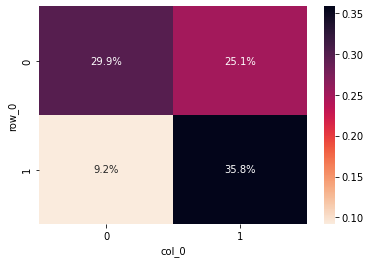

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=40, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(f'fb score:{fbeta_score(y_test, y_pred, average="macro", beta=0.5):.2f}')
print(f'score:{accuracy_score(y_test, y_pred):.2f}')

sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', cmap=sns.cm.rocket_r);
plt.show();

fb score:0.73
score:0.72


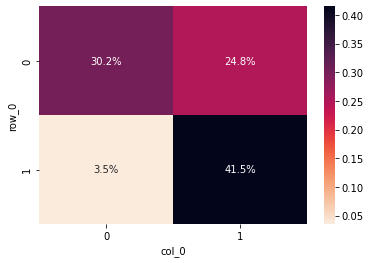

In [8]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.8, max_depth=10)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
print(f'fb score:{fbeta_score(y_test, y_pred, average="macro", beta=0.5):.2f}')
print(f'score:{accuracy_score(y_test, y_pred):.2f}')

sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', cmap=sns.cm.rocket_r);
plt.show();

# 3. Algorithmes généraux : house 2 vs house 1

In [9]:
# train data set = house 1
X_train = house2_power_blk1[features_col].values
y_train = house2_power_blk1['activity'].values

rand_indexes = pick_random_indexes(house1_power_blk2, 0.3)
# test data set = house 2
X_test = house1_power_blk2.loc[rand_indexes, features_col].values
y_test = house1_power_blk2.loc[rand_indexes, 'activity'].values

fb score:0.73
score:0.72


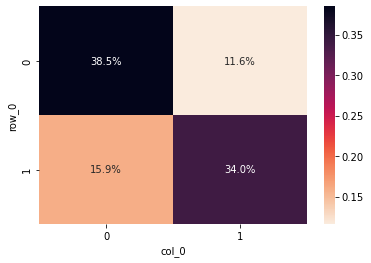

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score

knn = KNeighborsClassifier(n_neighbors=40, n_jobs=-1)
knn.fit(X_train, y_train.ravel())
y_pred = knn.predict(X_test)
print(f'fb score:{fbeta_score(y_test, y_pred, average="macro", beta=0.5):.2f}')
print(f'score:{accuracy_score(y_test, y_pred):.2f}')

sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', cmap=sns.cm.rocket_r);

fb score:0.76
score:0.76


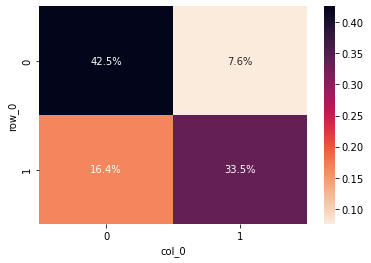

In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=30, n_jobs=-1, max_samples=0.8, max_depth=10)
rfc.fit(X_train, y_train.ravel())
y_pred = rfc.predict(X_test)
print(f'fb score:{fbeta_score(y_test, y_pred, average="macro", beta=0.5):.2f}')
print(f'score:{accuracy_score(y_test, y_pred):.2f}')

sns.heatmap(pd.crosstab(y_test, y_pred, normalize=True), annot=True, fmt='.1%', cmap=sns.cm.rocket_r);
plt.show();